In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from statistics import mean
from math import sqrt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neural_network
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 144, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [3]:
def graphRes(act, pred):
    ax = plt.gca()
    for pos in positions:
        ax.scatter(act[pos],pred[pos], label=f'{pos} ({r2_score(act[pos], pred[pos]).round(2)})')

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(labels)
    ax.plot(act['QB'],act['QB'],color='black') # y==x reference line
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

def printStats(y_dev, y_pred):
    # Adapt multioutput back to fan. pts.
    act = {}
    pred = {}
    dfPred = {}
    for pos in positions:
        act[pos] = y_dev[pos].fanPts
        dfPred[pos] = pd.DataFrame(y_pred[pos], columns = y_dev[pos].columns)
        ppr = 0
        if pos != 'QB':
            pred[pos] = dfPred[pos].yards_gained_seasonTotal/10 \
                            + 6 * (dfPred[pos].pass_touchdown_seasonTotal + dfPred[pos].rush_touchdown_seasonTotal) \
                            - 2 * dfPred[pos].fumble_seasonTotal \
                            + ppr * dfPred[pos].complete_pass_seasonTotal
        else:
            pred[pos] = dfPred[pos].yards_gained_seasonTotal/25 \
                            + 4 * dfPred[pos].pass_touchdown_seasonTotal \
                            + 6 * dfPred[pos].rush_touchdown_seasonTotal \
                            - 2 * dfPred[pos].fumble_seasonTotal \
                            - 2 * dfPred[pos].interception_seasonTotal

    graphRes(act, pred)

    stats = pd.DataFrame(index = ['MAE','RMSE','R^2'], columns = [positions])
    for pos in positions:
        stats.loc['MAE',pos] = mean_absolute_error(act[pos], pred[pos]).round(1)
        stats.loc['RMSE',pos] = round(math.sqrt(mean_squared_error(act[pos], pred[pos])),1)
        stats.loc['R^2',pos] = r2_score(act[pos], pred[pos]).round(2)
     
    display(stats)
    
def cvGrid(params, resGrid):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(resGrid)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [4]:
# Partition training, dev, and test data
positions = ['QB','RB','WR','TE']
tgtCols = ['yards_gained_seasonTotal','complete_pass_seasonTotal', 'fumble_seasonTotal','rush_touchdown_seasonTotal','pass_touchdown_seasonTotal','interception_seasonTotal','fanPts']

X_train, X_dev, X_test = {}, {}, {}
y_train, y_dev, y_test = {}, {}, {}
data = {}
X = {}
y = {}
for pos in positions:
    data[pos] = pd.read_csv(f'../expanded/{pos}.csv').dropna(subset=['fanPts'])
        
    # Split into features and targets
    X[pos] = data[pos].loc[:,data[pos].columns.str.contains('-\d+') | data[pos].columns.str.match('fanPts') | data[pos].columns.str.match('oppPtsAllowed')] \
        .drop('fanPts',axis=1) \
        .fillna(0)
    y[pos] = data[pos].loc[:,[x for x in tgtCols if x in data[pos].columns]]
    
    # Downselect useful X features
    featureInfo = pd.read_csv('../features.csv').iloc[:,0:-9]
    featureInfo = featureInfo.loc[featureInfo['Use']==1,:]
    featMap = {'QB':'Pass','RB':'Rush','WR':'Rec','TE':'Rec'}
    cols = featureInfo[featureInfo[featMap[pos]] == 1].Field.tolist()
    cols.extend(['fanPts_oppAllowTotal','QB','RB','WR','TE'])
    X[pos] = X[pos].loc[:,[x for x in X[pos].columns if any([x.startswith(y) for y in cols]) and '-' in x]]
    
        
    # Split train/dev/test
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X[pos], y[pos], test_size=0.3, random_state=0)
    X_dev_raw, X_test_raw, y_dev_raw, y_test_raw = train_test_split(X_test_raw, y_test_raw, test_size=0.5, random_state=0)
    
    # Scale X data
    ss = preprocessing.StandardScaler()
    X_train[pos] = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
    X_dev[pos] = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
    X_test[pos] = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)
    
    # Leave y data in original units
    y_train[pos] = y_train_raw
    y_dev[pos] = y_dev_raw
    y_test[pos] = y_test_raw

### Multi-layer Perceptron Regression

#### Base model

C:\Users\mrkawa\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


QB: 3 layers, 5000 iterations


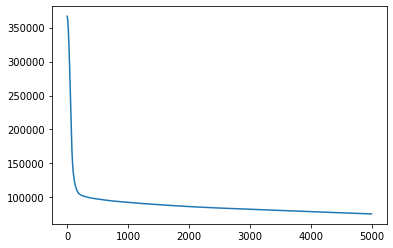

RB: 3 layers, 2952 iterations


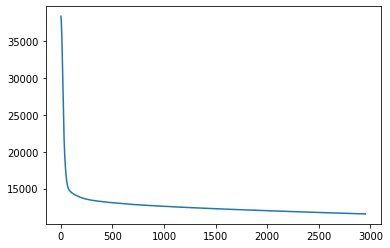

WR: 3 layers, 3430 iterations


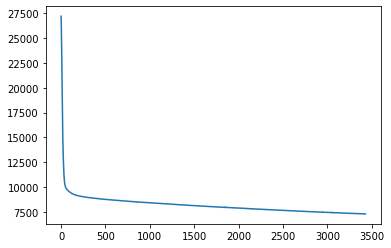

TE: 3 layers, 3678 iterations


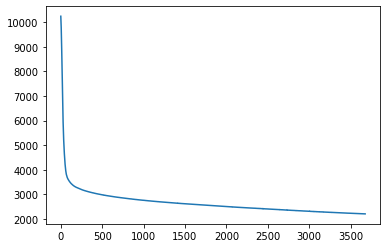

,QB,RB,WR,TE
MAE,55.700,41.200,40.700,23.700
RMSE,75.400,58.000,57.200,31.300
R^2,0.440,0.360,0.240,0.310


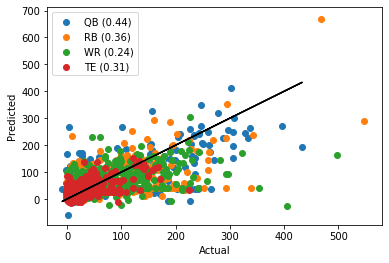

In [5]:
y_pred = {}
for pos in positions:
    m = neural_network.MLPRegressor(max_iter=5000)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.n_layers_} layers, {m.n_iter_} iterations')
    plt.plot(m.loss_curve_)
    plt.show()

printStats(y_dev, y_pred)

#### GridSearchCV

In [ ]:
y_pred = {}
bestParams = {}
maxIter = 5000
for pos in positions:
    inputNodes = len(X_train[pos].columns)
    outputNodes = len(y_train[pos].shape) if y_train[pos].shape == 2 else 1
    nSamples = len(X_train[pos])

    sizes = [
        mean([inputNodes,outputNodes]),
        (2/3)*inputNodes + outputNodes,
        sqrt(inputNodes*outputNodes),
        inputNodes*2-1
    ] + [nSamples/(x*(inputNodes+outputNodes)) for x in range(2,11)]# + [x for x in range(2,21)]

    params={
        'activation':['relu'],
        'solver':['lbfgs','adam'],
        'hidden_layer_sizes': list(set(map(int, sizes))),
        'alpha':[10**x for x in range(-5,1)],
    }

    grid = GridSearchCV(
        neural_network.MLPRegressor(warm_start=False,random_state=0,max_iter=maxIter),
        params,
        n_jobs = -1,
        verbose = 1,
        cv = 3
    ).fit(X_train[pos],y_train[pos])

    bestParams[pos] = grid.best_params_
    
    cvGrid(params, grid.cv_results_).to_csv(f'nn{pos}.csv')
    
    m = neural_network.MLPRegressor(**bestParams[pos],max_iter=maxIter)
    m.fit(X_train[pos],y_train[pos])
    y_pred[pos] = m.predict(X_dev[pos])
    
    print(f'{pos}: {m.n_layers_} layers, {m.n_iter_} iterations')
#     plt.plot(m.loss_curve_)
#     plt.show()
    
for pos in positions:
    print(f'{pos}: {bestParams[pos]}')
printStats(y_dev,y_pred)